# Fingerprint recognition

## Data
The dataset found at https://neurotechnology.com/download.html is composed by 408 .tif fingerprint images.
Originally the dataset contains 8 different images for each fingerprint and about 6 different fingers for each person. I will treat the different fingers as fingers belonging to distinct persons, so the dataset will contain fingerprints from 51 individuals.

## Fingercode extraction
Before doing the fingerprint recognition I extracted all the fingercodes and saved them as .txt files in order to avoid the extraction process every time.
To do so I used the MATLAB code provided by Luigi Rosa (https://github.com/hbhdytf/fingercode) that uses a bank of Gabor filters to capture both local and global details in a fingerprint as a compact fixed length fingercode. This MATLAB algorithm takes around 0.35 seconds for each image to be processed in order to extract the fingercode. Firstly it finds out the core point of the fingerprint image and around that it builds 5 concentric bands (wide 20 pixels each) all composed by 16 arcs but avoiding the inner circle of radius equal to 12 pixels (the central band is not considered because it is a too small area). Afterwars it uses 8 Gabor filters so the final fingercode will contain 1280 "bits" obtained by concatenating the results of two different rotations of the image (2(n_bands* n_arcs * n_Gabor_filters)).

## Data preparation
All the 408 fingercodes are stored in the "fingercodes" folder, but in order to compute the recognition algorithm and see its performances the dataset is split into training and test sets, with ratio 60:20. Therefore the training set simulates the server database in which are stored 6 fingercodes for each user, while the test set it's used to simulate the authentication request of an user trying to access a service.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.interpolate import interp1d
from utils_fingercode import *
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [2]:
train_images = get_all_fingercode('train')
test_images = get_all_fingercode('test')
print("Size of the training set: ", len(train_images))
print("Size of the training set: ", len(test_images))

Size of the training set:  306
Size of the training set:  102


Next we show one fingerprint and its related fingercode.

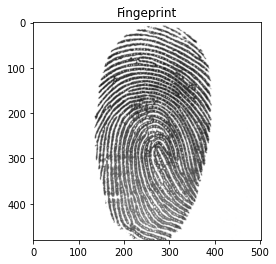

Fingercode: 
 11010000000011111111100000001111111110000001111100110000001111110011100000111110000000000001111000000000001110000000000000111000000000000011110000010000001111000000000001000000000000000110000000000000011000000000000001100000000000000110000000000000110000000000000011000000000000000100000000000000010000000000000011000000000000000100000000000000100000000000000010000000000000001000000000000001100000000000001100000000000000011000000000000001100000000000000100000000000000011000000011111100000000001100000100000001110000110000000011000111000000011100111100000001111111000000001111111100000001111111111000000111111111000000111111111110000111110000000000001111000100000000110100000000000111110001000000011110000110000011111000000000000001000000000000110000000000000011100000000000001100000001100000111000000000000110000000000000011000000000000001100000000000000110000000000000011000000000000001000000000000001100000000000000010000000000000001000000000000011100000000000001000000000000000010

In [3]:
img = mpimg.imread('fingerprints/178_4.tif')
plt.imshow(img)
plt.title('Fingeprint')
plt.show()
print('Fingercode: \n', read_from_file_fingercode('train/178_4.txt'))

## Results analysis
For each fingercode in the test folder let's see how it performs when compared to all other fingercodes located in the train folder. 
Starting from a test finger it will compute the Euclidean distance from every single train fingercode and also the mean distance from the 6 fingercodes available for every person in the train set. 

In [4]:
def result_analysis():
    total_mean = 0
    same_dist = 0
    diff_dist = 0
    different = 0
    same = 0

    for test in test_images:
        test_fingercode = read_from_file_fingercode(test)
        total_dist = 0
        count = 0
        for train in train_images:
            train_fingercode = read_from_file_fingercode(train)
            dist = euclidean_distance(test_fingercode, train_fingercode)
            total_dist += dist
            count += 1
            if get_fingercode_class(test) == get_fingercode_class(train):
                same_dist += dist
                same += 1
            else:
                diff_dist += dist
                different += 1
            print('Dist from {} to {} is {}'.format(test, train, round(dist)))
            if count == 6:
                count = 0
                mean = total_dist/6
                total_dist = 0
                print('***********************************************************')
                print('Mean dist from {} to all {} is {}'.format(test, get_fingercode_class(train), round(mean)))
                print('***********************************************************')

    print('---------------------------------------------------------------')
    print('Mean for same fingerprints = {}, for different ones = {}'.format(round(same_dist/same), round(diff_dist/different)))
    return 

# uncomment the next line if necessary
#result_analysis()

From the above results it is possible to notice that when comparing fingercodes from the same person the mean distance is 223 and that "good matches" are below 100, while the mean distance from the 6 wrong fingercodes is 386.

## Identification scenario
In the following lines of code I defined the identification scenario, which corresponds to 1:M classification problem. It is usually applied when some entity needs to identify a person by acquiring its biometric and then searching in the database in order to correctly identify the person.
By executing the identification scenario every fingercode in the test set will be compared to each one in the train set and the prediction will be stored. 
This procedure can run with different threshold values for the Euclidean distance, in order to evaluate which one performs better.

In [5]:
def perform_authentication_scenario(train_images, test_images, threshold):
    y_true = []
    y_pred = []
    for test in test_images:
        test_fingercode = read_from_file_fingercode(test)
        total_dist = 0
        count = 0
        single_pred = []
        multiple_pred = []
        matched = 0
        y_true.append(get_fingercode_class(test))

        for train in train_images:
            count += 1
            train_fingercode = read_from_file_fingercode(train)
            dist = euclidean_distance(test_fingercode, train_fingercode)
            total_dist += dist

            if dist < threshold:
                matched += 1
                if get_fingercode_class(train) not in single_pred:
                    single_pred.append(get_fingercode_class(train))

            if count == 6:
                count = 0
                total_dist = 0
                if matched >= 2:
                    multiple_pred.append(get_fingercode_class(train))
                matched = 0

        if len(multiple_pred) != 0:
            y_pred.append(multiple_pred[0])
        elif len(single_pred) != 0:
            y_pred.append(single_pred[0])
        else:
            y_pred.append('none')

    return y_true, y_pred

Now let's run the authentication scenario with different thresholds in order to see which one performs better in terms of accuracy.

Accuracy score for threshold 50 is 0.2353
Precision score for threshold 50 is 0.2353
F1 score for threshold 50 is 0.2353
-------------------------------------------------
Accuracy score for threshold 60 is 0.3431
Precision score for threshold 60 is 0.3431
F1 score for threshold 60 is 0.3431
-------------------------------------------------
Accuracy score for threshold 70 is 0.451
Precision score for threshold 70 is 0.451
F1 score for threshold 70 is 0.451
-------------------------------------------------
Accuracy score for threshold 80 is 0.6078
Precision score for threshold 80 is 0.6078
F1 score for threshold 80 is 0.6078
-------------------------------------------------
Accuracy score for threshold 90 is 0.6863
Precision score for threshold 90 is 0.6863
F1 score for threshold 90 is 0.6863
-------------------------------------------------
Accuracy score for threshold 100 is 0.7843
Precision score for threshold 100 is 0.7843
F1 score for threshold 100 is 0.7843
------------------------

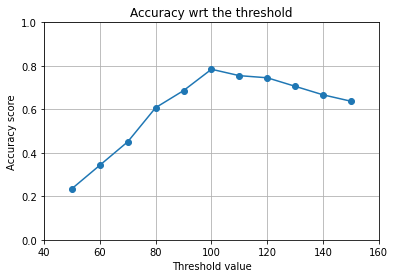

In [6]:
thresholds = []
accuracies = []
for threshold in range (50, 160, 10):
    y_true, y_pred = perform_authentication_scenario(train_images, test_images, threshold)
    print('Accuracy score for threshold {} is {}'.format(threshold, round(accuracy_score(y_true, y_pred), 4)))
    print('Precision score for threshold {} is {}'.format(threshold, round(precision_score(y_true, y_pred, average='micro'), 4)))
    print('F1 score for threshold {} is {}'.format(threshold, round(f1_score(y_true, y_pred, average='micro'), 4)))
    print('-------------------------------------------------')
    thresholds.append(threshold)
    accuracies.append(round(accuracy_score(y_true, y_pred), 4))
   
plt.plot(thresholds, accuracies, marker='o')
plt.title('Accuracy wrt the threshold')
plt.xlabel('Threshold value')
plt.ylabel('Accuracy score')
plt.axis([40, 160, 0, 1])
plt.grid(True)
plt.show()    

It is possible to observe that the higher accuracy is obatained when the threshold is 100. 

## FAR and FRR
False Acceptance Rate (FAR): the percentage of identification instances in which unauthorised persons are incorrectly accepted.
False Rejection Rate (FRR): the percentage of identification instances in which authorised persons are incorrectly rejected.

The rates of false rejections and false acceptances have a single point of intersection. The coincidence of percentage indicators at this point indicates the equality of the rates. Such a point is named the equal error rate (EER).
Ideally, the EER indicator should be zero, which means that FAR and FAR are also equal to zero. In practice, this is unattainable.

Let's now compute the FAR and the FRR for different threshold.

### FAR calculation
Let's test the model on the impostor dataset where we know that the dataset doesn’t contain any original image so all the predictions that will be made are wrong but we care about the prediction score (how many impostors pass at each threshold). The impostor dataset is compesed of 80 fingercodes.

In [7]:
impostor_images = get_all_fingercode('impostor')
thresholds = []
accepted = []

for threshold in range (50, 160, 10):
    wrong_pred = 0
    y_true, y_pred = perform_authentication_scenario(train_images, impostor_images, threshold)
    for pred in y_pred:
        if pred != 'none':
            wrong_pred +=1
    thresholds.append(threshold)
    accepted.append(round(wrong_pred/len(y_pred), 4))
    print('With threshold {} the wrongly accepted fingercodes are {}, corresponding to {}%'.format(threshold, wrong_pred, round(wrong_pred/len(y_pred)*100, 4)))

With threshold 50 the wrongly accepted fingercodes are 0, corresponding to 0.0%
With threshold 60 the wrongly accepted fingercodes are 0, corresponding to 0.0%
With threshold 70 the wrongly accepted fingercodes are 0, corresponding to 0.0%
With threshold 80 the wrongly accepted fingercodes are 0, corresponding to 0.0%
With threshold 90 the wrongly accepted fingercodes are 2, corresponding to 2.5%
With threshold 100 the wrongly accepted fingercodes are 5, corresponding to 6.25%
With threshold 110 the wrongly accepted fingercodes are 8, corresponding to 10.0%
With threshold 120 the wrongly accepted fingercodes are 12, corresponding to 15.0%
With threshold 130 the wrongly accepted fingercodes are 15, corresponding to 18.75%
With threshold 140 the wrongly accepted fingercodes are 21, corresponding to 26.25%
With threshold 150 the wrongly accepted fingercodes are 26, corresponding to 32.5%


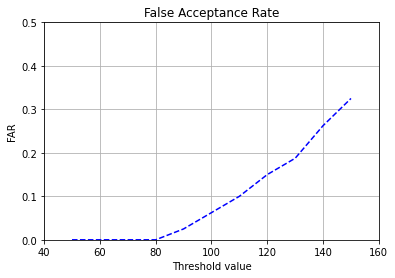

In [8]:
plt.plot(thresholds, accepted, '--b')
plt.title('False Acceptance Rate')
plt.xlabel('Threshold value')
plt.ylabel('FAR')
plt.axis([40, 160, 0, 0.5])
plt.grid(True)
plt.show()  

### FRR calculation
The curve of the FRR represents the case when a honest person gets rejected; by increasing the threshold the original chance to get rejected decreases.

In [9]:
test_images = get_all_fingercode('test')
thresholds = []
rejected = []

for threshold in range (50, 160, 10):
    wrong_pred = 0
    y_true, y_pred = perform_authentication_scenario(train_images, test_images, threshold)
    for pred in y_pred:
        if pred == 'none':
            wrong_pred +=1
    thresholds.append(threshold)
    rejected.append(round(wrong_pred/len(y_pred), 4))
    print('With threshold {} the wrongly rejected fingercodes are {}, corresponding to {}%'.format(threshold, wrong_pred, round(wrong_pred/len(y_pred)*100, 4)))

With threshold 50 the wrongly rejected fingercodes are 78, corresponding to 76.4706%
With threshold 60 the wrongly rejected fingercodes are 67, corresponding to 65.6863%
With threshold 70 the wrongly rejected fingercodes are 56, corresponding to 54.902%
With threshold 80 the wrongly rejected fingercodes are 40, corresponding to 39.2157%
With threshold 90 the wrongly rejected fingercodes are 32, corresponding to 31.3725%
With threshold 100 the wrongly rejected fingercodes are 20, corresponding to 19.6078%
With threshold 110 the wrongly rejected fingercodes are 20, corresponding to 19.6078%
With threshold 120 the wrongly rejected fingercodes are 18, corresponding to 17.6471%
With threshold 130 the wrongly rejected fingercodes are 15, corresponding to 14.7059%
With threshold 140 the wrongly rejected fingercodes are 13, corresponding to 12.7451%
With threshold 150 the wrongly rejected fingercodes are 12, corresponding to 11.7647%


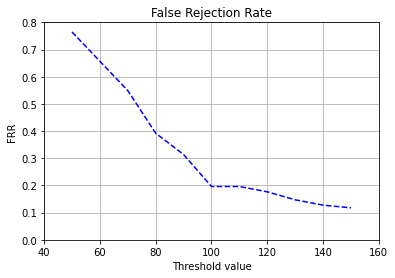

In [10]:
plt.plot(thresholds, rejected, '--b')
plt.title('False Rejection Rate')
plt.xlabel('Threshold value')
plt.ylabel('FRR')
plt.axis([40, 160, 0, 0.8])
plt.grid(True)
plt.show()  

### EER calculation
Let's now plot the FAR and the FRR toghether. Their intersection point is the EER value.

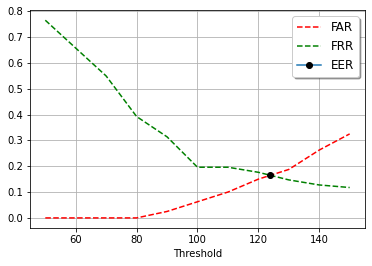

Cordinates of EER are (123.874, 0.165)


In [11]:
fig, ax = plt.subplots()

# compute the interpolation in order to calculate the intersection
f1 = interp1d(thresholds, accepted, kind = 'linear')
f2 = interp1d(thresholds, rejected, kind = 'linear')
xx = np.linspace(max(thresholds[0], thresholds[0]), min(thresholds[-1], thresholds[-1]), 1000)
y1_interp = f1(xx)
y2_interp = f2(xx)
idx = np.argwhere(np.diff(np.sign(y1_interp - y2_interp))).flatten()

ax.plot(thresholds, accepted, 'r--', label='FAR')
ax.plot(thresholds, rejected, 'g--', label='FRR')
ax.plot(xx[idx[0]], y1_interp[idx[0]], marker = 'o', markerfacecolor = 'black', markeredgecolor = 'black', label='EER')
plt.xlabel('Threshold')
plt.grid(True)
legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
plt.show()
print('Cordinates of EER are ({}, {})'.format(round(xx[idx[0]], 3), round(y1_interp[idx[0]], 3)))

So the equal error rate is 0.164.